In [ ]:
import re, json
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter

Author: Sayed Hesham Ahmed

This is a program that extracts data about covid patients from the MOH website, analyze them, encode in a JSON file then display some of it on a pie chart.

In [ ]:
# opening and reading the HTML file, then saving it in variable 'data'
siteText = open("contacttracing.htm", "r", encoding="utf-8")
data = siteText.read()
siteText.close()

In [ ]:
# storing age data from all patients
ageMatches = re.findall(r'Age:(?:\D*)*?\s*(\d+)\s*', data)
allAges =[int(age) for age in ageMatches]

In [ ]:
caseMatches = re.findall(r'Case No\.*:*\s*(?:\D*)*?(\d+)', data)
allCases =[int(case) for case in caseMatches]


In [ ]:
# storing nationality data of all patients
natMatches = re.findall(r'Nationality:(?:&.*;)*?\s*(?:</.*>)*?\s*[A-z]+', data)
allNationality = [nation[13:] for nation in natMatches] # storing without the word "nationality:"

for i in range(len(allNationality)): # removing unneeded data from nationality list
        allNationality[i] = re.sub(r'(nbsp;)|(<.*>)', '', allNationality[i], flags=re.IGNORECASE)
        allNationality[i] = allNationality[i].replace(':', '').replace('&', '')
        allNationality[i] = re.sub(r'(male)|(female)|(sex)', '', allNationality[i], flags=re.IGNORECASE)


The above cell only captures 754 patients, this is because apparently there is one patient with no nationality typed, so the regular expression did not capture it.

In [ ]:
genderMatches = re.findall(r'Sex:\s*(?:&.*;)*?\s*[\w]*', data)
genderMatches = [gender[4:] for gender in genderMatches]

for i in range(len(genderMatches)): # removing unneeded data from gender list and checking if any is empty (unstated/undefined)
    genderMatches[i] = re.sub(r'\s+', '', genderMatches[i], flags=re.IGNORECASE)
    if (genderMatches[i] == ""):
        genderMatches[i] = "Undefined"
        

In [ ]:
travelMatches = re.findall(r'Travel\sHistory:*\s*.*', data)
travelMatches = [i[14:] for i in travelMatches]

for i in range(len(travelMatches)):  # removing unneeded things and checking if empty (NA/no nationality listed)
    travelMatches[i] = re.sub(r':\s{0,1}','', travelMatches[i])
    travelMatches[i] = re.sub(r'<.*>','', travelMatches[i])
    travelMatches[i] = re.sub(r'&.{4};','', travelMatches[i])
    travelMatches[i] = re.sub(r'Arrived\sfrom','', travelMatches[i], flags=re.IGNORECASE)
    travelMatches[i] = re.sub(r'on.*','', travelMatches[i], flags=re.IGNORECASE)
    
    travelMatches[i] = re.sub(r'\s*Contact\s*Tracing', '', travelMatches[i], flags=re.IGNORECASE)
    if (travelMatches[i] == ""):
        travelMatches[i] = "NA"


In [ ]:
tracingMatches = re.findall(r'Contact\sTracing:.*?</td>', data, re.DOTALL)
tracingMatches = [i[16:] for i in tracingMatches]

for i in range(len(tracingMatches)):
    tracingMatches[i] = re.sub(r'^\s*', "", tracingMatches[i])
    tracingMatches[i] = re.sub(r'<.*>', "", tracingMatches[i])
    tracingMatches[i] = re.sub(r'&.*;', "", tracingMatches[i])
    tracingMatches[i] = re.sub(r'\n', "", tracingMatches[i])
    tracingMatches[i] = re.sub(r'\s+$', "", tracingMatches[i])
    tracingMatches[i] = re.sub(r'Case No\.*:*\s*(?:\D*)*?(\d+)',"", tracingMatches[i])


In [ ]:
# storing date in JSON format file with today's date
date = datetime.now().strftime("%d-%m-%Y") 
fileName = f"{date}.json"

with open(fileName, "w") as json_file:
    json.dump(["Cases:", allCases], json_file)
    json_file.write("\n")
    json.dump(["Ages:", allAges], json_file)
    json_file.write("\n")
    json.dump(["Nationalities:", allNationality], json_file)
    json_file.write("\n")
    json.dump(["Sexes:", genderMatches], json_file)
    json_file.write("\n")
    json.dump(["Travel History:", travelMatches], json_file)
    json_file.write("\n")
    json.dump(["Contact Tracing:", tracingMatches], json_file)


In [ ]:
# analyzing needed data
temp = travelMatches
for i in range(len(temp)):
    match = re.search(r'Arrived\sfrom\s(\S+)', temp[i])
    if match:
        temp[i] = match.group(1)
    temp[i] = re.sub(r'^\s+', "", temp[i])
    temp[i] = re.sub(r'\s+$', "", temp[i])
    temp[i] = re.sub(r'Travel History ', "",temp[i])
    match2 = re.search((r'NA.*'),temp[i])
    if match2:
        temp[i]="Not applicable"
        

topNations = Counter(temp).most_common(3)
print("The countries where most infections came from:")
for i, (country, count) in enumerate(topNations, 1):
    print(f"{i}. {country}, {count} infections")

print("\n\nThe gender of the infected:")
genderCounter= Counter(genderMatches)
for gender, counter in genderCounter.items():
    print(gender + ",", counter)

The countries where most infections came from:
1. Not applicable, 373 infections
2. Iran, 265 infections
3. UK, 53 infections


The gender of the infected:
Male, 412
Female, 225
Undefined, 118


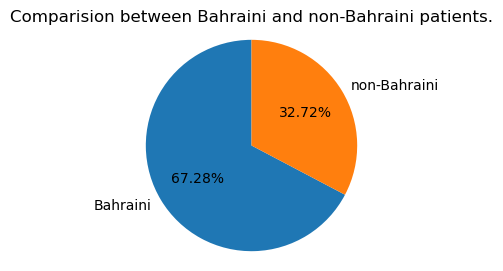

In [ ]:
# visualizing needed data
bahrainiCount = Counter(allNationality).get("Bahraini",0)
nonBahrainiCount = len(allNationality) - bahrainiCount

plt.figure(figsize=(3,3))
plt.pie([bahrainiCount+1, nonBahrainiCount], labels=["Bahraini", "non-Bahraini"], autopct='%1.2f%%', startangle=90)
plt.title("Comparision between Bahraini and non-Bahraini patients.")
plt.axis('equal')
plt.show()